# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'bandgap'
folder = 'bandgaps-MChX'

r_folder = f'models/{folder}'
t_folder = r_folder
#t_folder = f'datasets/bandgap-EPA'
model_name = f'{r_folder}/{target}-model.pt'

# Generate or load graph database for training

Reference dataset

In [3]:
r_dataset_name_std      = f'{r_folder}/r_dataset_std.pt'
r_labels_name_std       = f'{r_folder}/r_labels_std.pt'
r_std_parameters_name   = f'{r_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions
r_uncertainty_data_name = f'{r_folder}/uncertainty_data.json'

# Load the standardized dataset, with corresponding labels and parameters
r_dataset_std = torch.load(r_dataset_name_std)
r_labels_std  = torch.load(r_labels_name_std)

# Load the data from the JSON file
with open(r_uncertainty_data_name, 'r') as json_file:
    r_uncertainty_data = json.load(json_file)

# Load the data from the JSON file
with open(r_std_parameters_name, 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert torch tensors to numpy arrays
r_std_parameters = {}
for key, value in numpy_dict.items():
    try:
        r_std_parameters[key] = torch.tensor(value)
    except:
        r_std_parameters[key] = value

# Load the data from the JSON file
with open(f'{r_folder}/dataset_parameters.json', 'r') as json_file:
    r_dataset_parameters = json.load(json_file)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(r_dataset_parameters['database_target']) if t == target][0]
r_std_parameters['target_mean'] = r_std_parameters['target_mean'][target_idx]
r_std_parameters['target_std']  = r_std_parameters['target_std'][target_idx]

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

/tmp/ipykernel_250493/1067142364.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r_dataset_std = torch.load(r_dataset_name_std)
/tmp/ipykernel_250493/1067142364.py:8: Fu

Prediciton dataset

In [4]:
t_dataset_name = f'{t_folder}/dataset.pt'

# Load the standardized dataset, with corresponding labels and parameters
t_dataset = torch.load(t_dataset_name)

# Standardize the dataset with
t_dataset_std = cld.standarize_dataset_from_keys(t_dataset, r_std_parameters)

# Select the target we want
ground_truths = [data.y[target_idx].item() for data in t_dataset]
del t_dataset

/tmp/ipykernel_250493/2984161968.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_dataset = torch.load(t_dataset_name)


# Load model and make predictions

In [5]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=r_dataset_std[0].num_node_features, pdropout=0)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

# Compute predictions
predictions, uncertainties = clm.make_predictions(r_dataset_std, r_labels_std,
                                                  t_dataset_std, model, r_std_parameters, r_uncertainty_data)

/tmp/ipykernel_250493/2957459338.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))


(62, 32) (64, 32) (62,)
(62, 32) (61, 32) (62,)


In [6]:
predictions

array([1.7540555, 1.8717798, 1.4055401, 1.5109257, 1.8424451, 1.4238257,
       1.5381547, 1.7240523, 1.8059944, 1.6364254, 1.4364569, 1.4420574,
       1.8880438, 1.7621933, 1.5193112, 1.4878368, 1.8273028, 1.7805667,
       1.4519646, 1.4405727, 1.7206806, 1.458605 , 1.6603653, 1.5040427,
       1.5349865, 1.7237955, 1.6314111, 1.4928995, 1.670063 , 1.5248682,
       1.6190466, 1.8608105, 1.8847078, 1.4638323, 1.4843129, 1.7312125,
       1.3868226, 1.5881004, 1.5601618, 1.360255 , 1.5341018, 1.4055203,
       1.8007848, 1.7529924, 1.4615556, 1.4503921, 1.3466041, 1.5477619,
       1.6846173, 1.6521083, 1.5279711, 1.7184913, 1.370559 , 1.6017408,
       1.505303 , 1.7279178, 1.6600945, 1.4468951, 1.5292786, 1.4450058,
       1.5151631, 1.8616314, 1.4495131, 1.736071 , 1.729152 , 1.7650416,
       1.8311383, 1.7578036, 1.6958992, 1.4742159, 1.7669606, 1.5391687,
       1.5449204, 1.4681206, 1.4734832, 1.6987602, 1.4061584, 1.3940325,
       1.5800296, 1.754595 , 1.5086877, 1.57932  , 

In [7]:
uncertainties

array([-0.07287165,  0.13059992,  0.01561054, -0.00139515,  0.05038024,
       -0.16198288, -0.03535815, -0.0595828 , -0.01697437, -0.0152205 ,
       -0.18215265, -0.02857104,  0.09655562,  0.05053314,  0.01658207,
       -0.03715441, -0.01181054,  0.05176067, -0.07286735, -0.09775146,
        0.00230497, -0.08642132, -0.05468814, -0.0170627 , -0.00500415,
       -0.03468683,  0.0294924 , -0.05529912, -0.11839335,  0.03936819,
       -0.02189159,  0.10230788,  0.02375419,  0.00711255,  0.02424604,
       -0.03208669, -0.1694384 ,  0.01820397, -0.01629519, -0.06364363,
        0.05125857, -0.05159331, -0.01546508, -0.05650076, -0.14522849,
        0.02731247, -0.04192678, -0.11185889, -0.07979392, -0.06195321,
       -0.06059086,  0.02385544, -0.00917281, -0.0202692 ,  0.0112282 ,
       -0.06443755, -0.06487589, -0.12493591, -0.0570514 , -0.01195818,
        0.02624744,  0.06686065,  0.00936041,  0.04590413, -0.08923657,
       -0.02421264, -0.03864199, -0.03573407,  0.03765098, -0.04

# Plot predictions

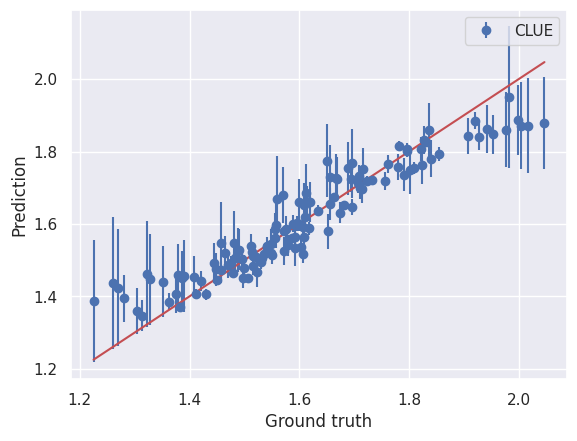

In [8]:
stack = np.concatenate([ground_truths, predictions])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.errorbar(ground_truths, predictions, yerr=np.abs(uncertainties),
             fmt='o', label='CLUE')
plt.plot([_min_, _max_], [_min_, _max_], '-r')


plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(loc='best')
plt.savefig('UQ-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

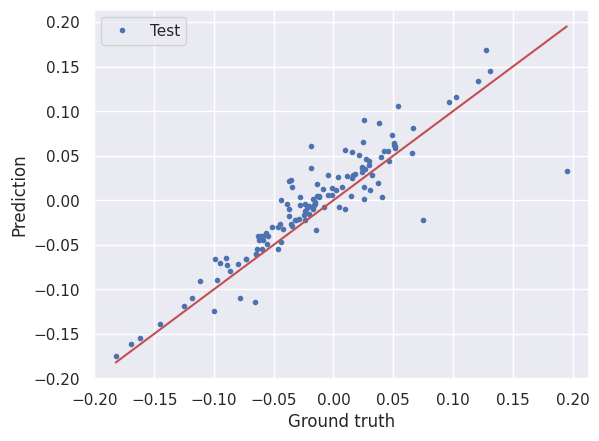

In [9]:
gt_uncertainties   = ground_truths - predictions
pred_uncertainties = uncertainties

stack = np.concatenate([gt_uncertainties, pred_uncertainties])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.plot(pred_uncertainties, gt_uncertainties,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.legend(loc='best')
plt.savefig('UQ-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()